In [275]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from counterbalance import CounterbalancedStratifiedSplit
from tqdm import tqdm_notebook

%matplotlib inline

Corr(y,c): 0.527
Corr(y,X): 0.235
Corr(c,X): -0.284

Corr(y,c): 0.170
Corr(y,X): 0.441
Corr(c,X): -0.303


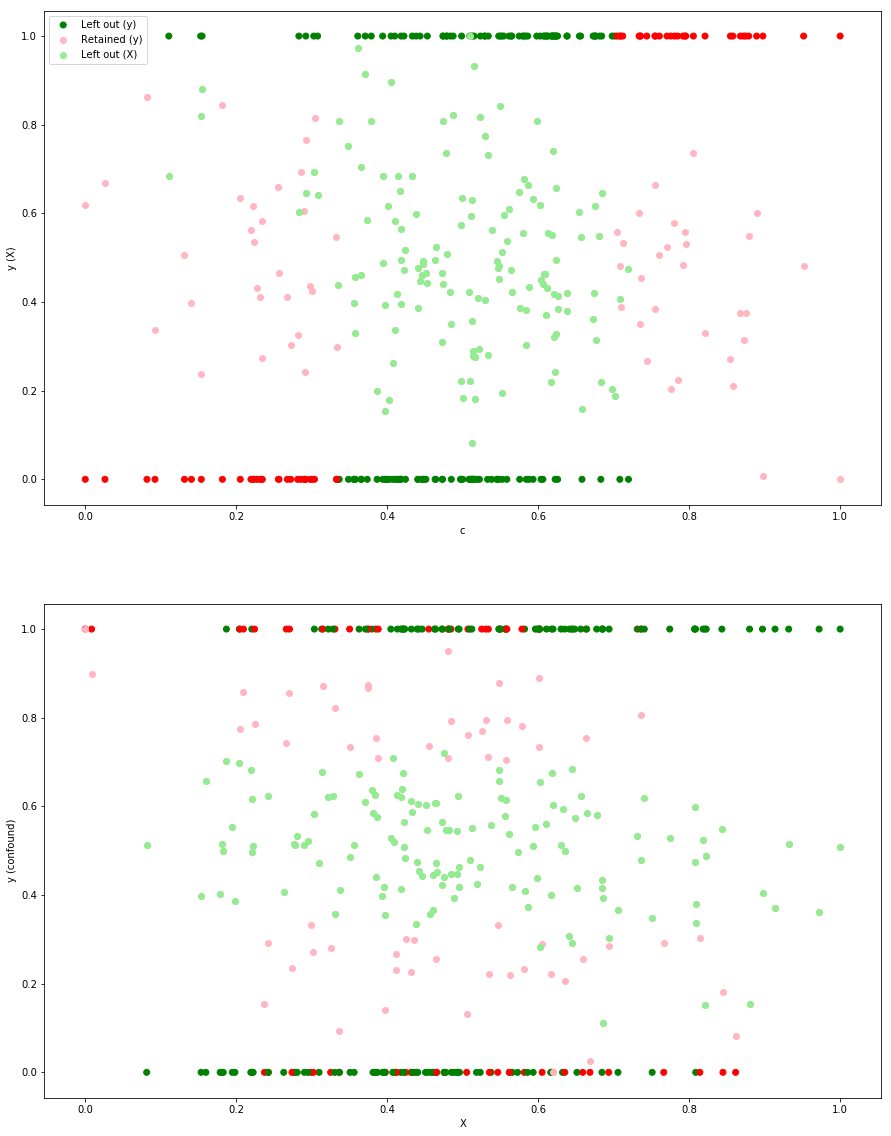

In [278]:
N = 200data = np.random.multivariate_normal(mean=np.zeros(K), cov=cov, size=N, tol=0.001)
y, X, c = data[:, 0], data[:, 1, np.newaxis], data[:, 2]
X = minmax.fit_transform(X)
c = minmax.fit_transform(c[:, np.newaxis]).squeeze()
y = (y > y.mean()).astype(int)

print("Corr(y,c): %.3f" % pearsonr(y, c)[0])
print("Corr(y,X): %.3f" % pearsonr(y, X.squeeze())[0])
print("Corr(c,X): %.3f" % pearsonr(c, X.squeeze())[0], end='\n\n')

cbss = CounterbalancedStratifiedSplit(X=X, y=y, c=c, n_splits=5, c_type='continuous',
                                      metric='tstat', use_pval=True, threshold=0.05)
cbss.check_counterbalance_and_subsample()
Xss, yss, css = X[cbss.subsample_idx], y[cbss.subsample_idx], c[cbss.subsample_idx]
K = 3

cov = np.array([
    [1, .3, .65],  # y, X, c
    [.3, 1, -.3],
    [.65, -.3, 1]
])

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='linear'))
])

minmax = MinMaxScaler()

data = np.random.multivariate_normal(mean=np.zeros(K), cov=cov, size=N, tol=0.001)
y, X, c = data[:, 0], data[:, 1, np.newaxis], data[:, 2]
X = minmax.fit_transform(X)
c = minmax.fit_transform(c[:, np.newaxis]).squeeze()
y = (y > y.mean()).astype(int)

print("Corr(y,c): %.3f" % pearsonr(y, c)[0])
print("Corr(y,X): %.3f" % pearsonr(y, X.squeeze())[0])
print("Corr(c,X): %.3f" % pearsonr(c, X.squeeze())[0], end='\n\n')

cbss = CounterbalancedStratifiedSplit(X=X, y=y, c=c, n_splits=5, c_type='continuous',
                                      metric='tstat', use_pval=True, threshold=0.05)
cbss.check_counterbalance_and_subsample()
Xss, yss, css = X[cbss.subsample_idx], y[cbss.subsample_idx], c[cbss.subsample_idx]
colors_selected = ['g' if s in cbss.subsample_idx else 'r' for s in range(y.size)]

print("Corr(y,c): %.3f" % pearsonr(yss, css)[0])
print("Corr(y,X): %.3f" % pearsonr(yss, Xss.squeeze())[0])
print("Corr(c,X): %.3f" % pearsonr(css, Xss.squeeze())[0])
y = np.repeat([0, 1], repeats=50)
c = np.random.normal(0, 1, (100))
x = .5 * y + c * -0.5 + np.random.normal(0, 1, 100)
plt.figure(figsize=(15, 20))
plt.subplot(2, 1, 1)
plt.scatter(c, y, c=colors_selected)
plt.scatter(c, X, c='lightpink')
plt.scatter(css, Xss, c='lightgreen')

plt.legend(['Left out (y)', 'Retained (y)', 'Left out (X)', 'Retained (X)'])
plt.ylabel("y (X)")
plt.xlabel("c")

plt.subplot(2, 1, 2)
plt.scatter(X, y, c=colors_selected)
plt.scatter(X, c, c='lightpink')
plt.scatter(Xss, css, c='lightgreen')
plt.ylabel('y (confound)')
plt.xlabel('X')

plt.show()

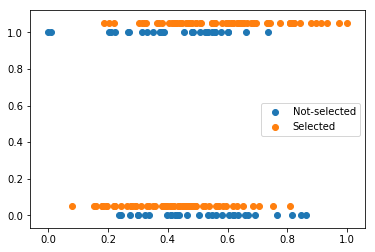

In [279]:
non_idx = list(set(range(y.size)) - set(cbss.subsample_idx))
plt.scatter(X[non_idx], y[non_idx])
plt.scatter(X[cbss.subsample_idx], y[cbss.subsample_idx] + 0.05)
plt.legend(['Not-selected', 'Selected'])

In [287]:
iters = 100
scores_cb = np.zeros(iters)
scores_no_cb = np.zeros(iters)
scores_diff_non = np.zeros(iters)
scores_diff = np.zeros(iters)

for i in tqdm_notebook(range(iters)):
    
    data = np.random.multivariate_normal(mean=np.zeros(K), cov=cov, size=N, tol=0.001)
    y, X, c = data[:, 0], data[:, 1, np.newaxis], data[:, 2]
    y = (y > y.mean()).astype(int)
    cbss = CounterbalancedStratifiedSplit(X=X, y=y, c=c, n_splits=5, c_type='continuous',
                                          metric='tstat', use_pval=True, threshold=0.05)
    cbss.check_counterbalance_and_subsample()
    Xss, yss, css = X[cbss.subsample_idx], y[cbss.subsample_idx], c[cbss.subsample_idx]
    
    scores_diff_non[i] = X[non_idx][y[non_idx] == 0].mean() - X[non_idx][y[non_idx] == 1].mean()
    scores_diff[i] = X[cbss.subsample_idx][y[cbss.subsample_idx] == 0].mean() - X[cbss.subsample_idx][y[cbss.subsample_idx] == 1].mean()
    
    scores_cb[i] = cross_val_score(pipe, Xss, yss, cv=10).mean()
    scores_no_cb[i] = cross_val_score(pipe, X, y, cv=10).mean()
    

In [375]:
iters = 10
scores_cb = np.zeros((iters, 8))
scores_no_cb = np.zeros((iters, 8))

for i in tqdm_notebook(range(iters)):
    
    for ii, K in enumerate([1, 10, 100, 500, 1000, 5000, 10000, 100000]):
        y = np.repeat([0, 1], repeats=50)
        c = np.roll(y, 5)
        X = (-1*y + c)[:, np.newaxis] + np.random.normal(0, 1, (100, K))
        #data = np.random.multivariate_normal(mean=np.zeros(K), cov=cov, size=N, tol=0.001)
        #y, X, c = data[:, 0], data[:, 1, np.newaxis], data[:, 2]
        #y = (y > y.mean()).astype(int)
        cbss = CounterbalancedStratifiedSplit(X=X, y=y, c=c, n_splits=5, c_type='categorical',
                                              metric='corr', use_pval=True, threshold=0.05)
        cbss.check_counterbalance_and_subsample()
        Xss, yss, css = X[cbss.subsample_idx], y[cbss.subsample_idx], c[cbss.subsample_idx]

        scores_cb[i, ii] = cross_val_score(pipe, Xss, yss, cv=10).mean()
        scores_no_cb[i, ii] = cross_val_score(pipe, X, y, cv=10).mean()

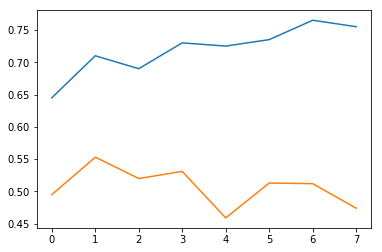

In [378]:
plt.plot(scores_cb.mean(axis=0))
plt.plot(scores_no_cb.mean(axis=0))